In [1]:
!pip install psmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# import other relevant libraries (that you want) 
import seaborn as sns
import pandas as pd
import numpy as np

# set the figure shape and size of outputs (optional)
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)


In [7]:
from psmpy import PsmPy
from psmpy.functions import cohenD
# from psmpy.plotting import *

In [8]:
# read in your data
path ="http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
data = pd.read_csv(path)

In [ ]:
data

# バイアスのあるデータの作成

In [55]:
# male_df 
# data[  (data["mens"]==0)  &  (data["womens"]==0)]  ##     0rows
# data[  (data["mens"]==1)  &  (data["womens"]==1)]  ## 6448rows
# data[  (data["mens"]==0)  &  (data["womens"]==1)]  ##28734rows
male_df = data[  (data["mens"]==1)  &  (data["womens"]==0)]  ##28818rows
male_df["treatment"] =male_df["segment"].apply(lambda x: 1 if x in ["Mens E-Mail"] else 0)

<ipython-input-55-c3acd51e85c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df["treatment"] =male_df["segment"].apply(lambda x: 1 if x in ["Mens E-Mail"] else 0)


In [56]:
male_df["treatment"].value_counts()

0    19260
1     9558
Name: treatment, dtype: int64

AttributeError: ignored

In [57]:
obs_rate_c = 0.5
obs_rate_t = 0.5

In [ ]:
## バイアスのあるデータを作成

tmp1 = male_df [(male_df["history"] >300) | 
                 (male_df["recency"] >6) |
                 (male_df["channel"] == "Multichannel")]

tmp2 = male_df [~((male_df["history"] >300) |
                 (male_df["recency"] >6) |
                 (male_df["channel"] == "Multichannel"))]
tmp1["obs_rate_c"] =  obs_rate_c
tmp2["obs_rate_c"] =  1

tmp1["obs_rate_t"] =  1
tmp2["obs_rate_t"] =  obs_rate_t

In [59]:
# biased_data <- male_df %>%
#   mutate(obs_rate_c = ifelse( (history > 300) | (recency < 6) | (channel == "Multichannel"), obs_rate_c, 1),
#          obs_rate_t = ifelse( (history > 300) | (recency < 6) | (channel == "Multichannel"), 1, obs_rate_t),
#          random_number = runif(n = NROW(male_df))) %>%
#   filter( (treatment == 0 & random_number < obs_rate_c ) |
#             (treatment == 1 & random_number < obs_rate_t) )

SyntaxError: ignored

In [ ]:
tmp = pd.concat([tmp1, tmp2])#28818
tmp

In [63]:
np.random.seed(233)  #233は適当
tmp["random_number"]= np.random.rand(tmp.shape[0]).tolist() #tmp.shape[0]は、28818

In [ ]:
tmp

In [115]:
tmp_aa =tmp[ (tmp["treatment"]==0) & (tmp["random_number"] < tmp["obs_rate_c"] ) ] #13263 
tmp_bb =tmp[ (tmp["treatment"]==1) & (tmp["random_number"] < tmp["obs_rate_t"] ) ] # 7695
biased_data = pd.concat([tmp_aa,tmp_bb]) #20958 

In [116]:
biased_data["treatment"].value_counts()

0    13263
1     7695
Name: treatment, dtype: int64

# 傾向スコアの推定

## import

In [68]:
# パッケージの説明

import pandas as pd
import numpy as np

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import random
import math
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Logistic Regression

In [83]:
biased_for_logistic = biased_data[["treatment","recency","history","channel"]]
biased_for_logistic

,treatment,recency,history,channel
0,0,10,142.44,Phone
45,0,10,29.99,Phone
46,0,2,391.33,Web
57,0,3,549.29,Multichannel
71,0,10,31.12,Phone
...,...,...,...,...
63898,1,3,261.06,Web
63941,1,2,130.96,Phone
63955,1,1,29.99,Phone
63982,1,5,29.99,Phone


In [84]:
biased_for_logistic =pd.get_dummies(biased_for_logistic, drop_first=True)
biased_for_logistic

,treatment,recency,history,channel_Phone,channel_Web
0,0,10,142.44,1,0
45,0,10,29.99,1,0
46,0,2,391.33,0,1
57,0,3,549.29,0,0
71,0,10,31.12,1,0
...,...,...,...,...,...
63898,1,3,261.06,0,1
63941,1,2,130.96,1,0
63955,1,1,29.99,1,0
63982,1,5,29.99,1,0


In [85]:
train_x = biased_for_logistic.drop(columns=["treatment"])
train_X = sm.add_constant(train_x)
train_y = biased_for_logistic[["treatment"]]

In [87]:
glm_model = sm.GLM(train_y, train_X, family=sm.families.Binomial())

glm_reslt = glm_model.fit()

In [ ]:
glm_reslt.summary()

<Axes: >

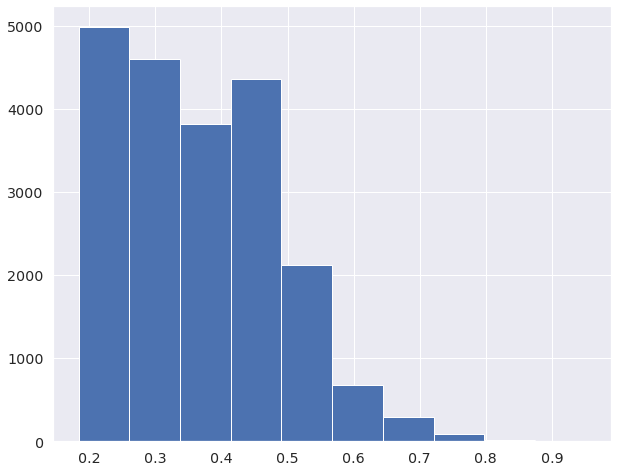

In [90]:
pred = glm_reslt.predict(train_X)
pred.hist() #check

In [101]:
(pred >=0.5).sum()

2846

In [102]:
(pred <0.5).sum()

18112

## propensity score matching

In [117]:
biased_for_logistic.reset_index(inplace=True)
biased_for_logistic

,index,treatment,recency,history,channel_Phone,channel_Web
0,0,0,10,142.44,1,0
1,45,0,10,29.99,1,0
2,46,0,2,391.33,0,1
3,57,0,3,549.29,0,0
4,71,0,10,31.12,1,0
...,...,...,...,...,...,...
20953,63898,1,3,261.06,0,1
20954,63941,1,2,130.96,1,0
20955,63955,1,1,29.99,1,0
20956,63982,1,5,29.99,1,0


In [118]:
psm = PsmPy(biased_for_logistic, treatment='treatment', indx='index', exclude = [])

In [119]:
psm.logistic_ps(balance = True)

##  理解していない。balenace+Trueとは？
## https://towardsdatascience.com/psmpy-propensity-score-matching-in-python-a3e0cd4d2631

In [ ]:
train = df[df['data'] == 1]
train = train.drop('data', axis=1)
# test = df[df['data'] == 0]
# test = test.drop(['y','data'], axis = 1)

train_x = train.drop(columns=["y"])
train_X = sm.add_constant(train_x)
train_y = train[["y"]]